In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

%matplotlib inline

from scipy.stats import zscore

In [2]:
# load and read the data
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.shape

(284807, 31)

In [3]:
# Get the Dataframe basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# Check missing values
print(df.isnull().sum())  

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


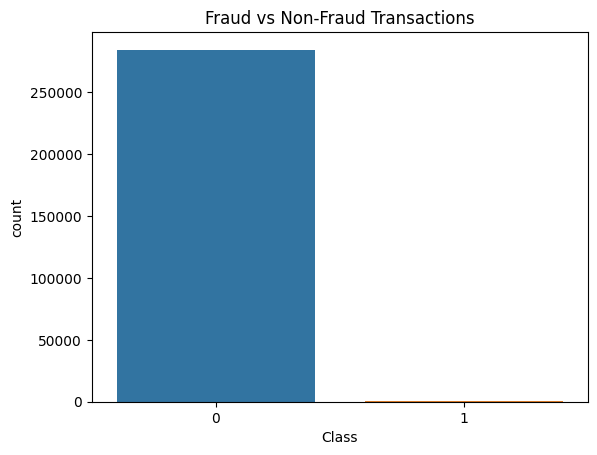

In [5]:
# Count of Fraud vs Non-Fraud Transactions
sns.countplot(x="Class", data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

In [6]:
# Print Class distribution
fraud_cases = df["Class"].value_counts()
print(fraud_cases)

Class
0    284315
1       492
Name: count, dtype: int64


In [7]:
# Normalize Amount column (since PCA was not applied to it)
df["Amount"] = StandardScaler().fit_transform(df[["Amount"]])

# Drop unnecessary columns
df = df.drop(columns=["Time"])  # Drop time since it's not useful for EM

# Print new dataset info
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# 1. What Do We Apply the EM Algorithm To?
The Expectation-Maximization (EM) algorithm is generally applied to unlabeled data where we assume that the data points belong to different underlying distributions (or clusters) but we don’t know which ones.

For Credit Card Fraud Detection, we typically apply EM to:

* All numerical features (like PCA-transformed variables in creditcard.csv).

* Transaction Amount (since large transactions could indicate fraud).

* Other engineered features (such as frequency of transactions per user).

The goal is to find hidden clusters in the data:

* One cluster may represent normal transactions.

* Another may represent fraudulent transactions.

# 2. How is the EM Algorithm Usually Implemented?
The EM algorithm is used to estimate the parameters of a mixture of distributions (e.g., Gaussian Mixture Models). It has two key steps:

Step 1: Initialize Parameters
Assume the data follows a mixture of K Gaussian distributions (for fraud detection, K = 2 is a common choice: fraud vs non-fraud).

* Initialize means, variances, and weights of each Gaussian.

Step 2: Expectation (E-Step)
* Compute the probability that each data point belongs to each cluster using Bayes’ Theorem.

Step 3: Maximization (M-Step)
* Recalculate the means, variances, and weights to maximize the likelihood of the data given the assignments.

Step 4: Iterate Until Convergence
* Repeat the E-step and M-step until the change in parameters is small.

# 3. Implementing EM for Credit Card Fraud Detection
We can use Gaussian Mixture Models (GMM), which is a probabilistic clustering method based on EM.

In [8]:
# Drop the 'Class' column since it's unsupervised learning
X = df.drop(columns=["Class"])
y = df["Class"]  # Keep for evaluation later

# Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Training Set: (227845, 29), Testing Set: (56962, 29)


# 4. How to Evaluate EM for Fraud Detection?
Since we have true fraud labels (Class), we can evaluate how well EM detects fraud by:

Checking Cluster Assignments vs. True Labels

Using ROC-AUC Score to measure how well it distinguishes fraud:

In [9]:
covariance_types = ['full', 'diag', 'tied', 'spherical']
best_auc = 0
best_model = None
best_params = {}

# Iterate through different covariance types
for cov_type in covariance_types:
    print(f"\nTesting covariance type: {cov_type}")
    
    # Iterate through different numbers of clusters
    for n_clusters in range(2, 5):
        gmm = GaussianMixture(n_components=n_clusters, covariance_type=cov_type, random_state=42)
        
        # Train on training set
        gmm.fit(X_train)
        
        # Predict fraud probabilities on test set
        test_probs = gmm.predict_proba(X_test)[:, 1]  # Probability of fraud
        
        # Evaluate with ROC-AUC score
        auc_score = roc_auc_score(y_test, test_probs)
        
        print(f"Clusters: {n_clusters}, AUC Score: {auc_score}")
        
        # Save the best model
        if auc_score > best_auc:
            best_auc = auc_score
            best_model = gmm
            best_params = {'covariance_type': cov_type, 'n_clusters': n_clusters}

print("\nBest Model Parameters:", best_params)
print("Best Model AUC Score:", best_auc)


Testing covariance type: full
Clusters: 2, AUC Score: 0.7128835144074511
Clusters: 3, AUC Score: 0.1482865849631918
Clusters: 4, AUC Score: 0.46998100731570064

Testing covariance type: diag
Clusters: 2, AUC Score: 0.9312426785570729
Clusters: 3, AUC Score: 0.9402297497502095
Clusters: 4, AUC Score: 0.059025724105061274

Testing covariance type: tied
Clusters: 2, AUC Score: 0.6700427550733292
Clusters: 3, AUC Score: 0.48139061477151357
Clusters: 4, AUC Score: 0.5116942106048947

Testing covariance type: spherical
Clusters: 2, AUC Score: 0.9512183742377085
Clusters: 3, AUC Score: 0.9559218629770423
Clusters: 4, AUC Score: 0.056320109993913146

Best Model Parameters: {'covariance_type': 'spherical', 'n_clusters': 3}
Best Model AUC Score: 0.9559218629770423


# Conclusions:

# 1. Best Performing Model
* The best covariance type was spherical with 3 clusters (n_clusters=3).

* It achieved the highest AUC score of 0.9559, meaning it best distinguishes fraud from non-fraud.

* The second-best performer was diag covariance with 3 clusters, achieving 0.9402 AUC.

# 2. Performance Comparison Across Covariance Types
🔹 Full Covariance
Best AUC: 0.7129 (2 clusters)

Performance dropped significantly for 3 and 4 clusters.

Suggests that full covariance is not ideal for this dataset, possibly due to high complexity in parameter estimation.

🔹 Diagonal Covariance (diag)
Best AUC: 0.9402 (3 clusters)

Generally performed better than full and tied, meaning feature independence assumptions might work well.

Performance collapsed at 4 clusters (AUC = 0.059), indicating overfitting or poorly separated clusters.

🔹 Tied Covariance
Best AUC: 0.6700 (2 clusters)

Consistently underperformed, suggesting the assumption of a shared covariance structure was too restrictive for this dataset.

🔹 Spherical Covariance (Best Choice)
Best AUC: 0.9559 (3 clusters)

Highest fraud detection capability.

Like diag, it collapsed at 4 clusters (AUC = 0.056), reinforcing that too many clusters reduce accuracy.

Final Nores:
* More clusters don’t always improve results—increasing from 3 to 4 clusters caused a drastic drop in AUC across all covariance types.
* The poor performance of full and tied suggests that simpler covariance structures (like spherical and diag) are more effective for fraud detection in this dataset.